In [1]:
import pandas

size_log = pandas.read_pickle("5-generated-mdps/success.pkl.gz")
aborts = pandas.read_pickle("5-generated-mdps/fail.pkl.gz")

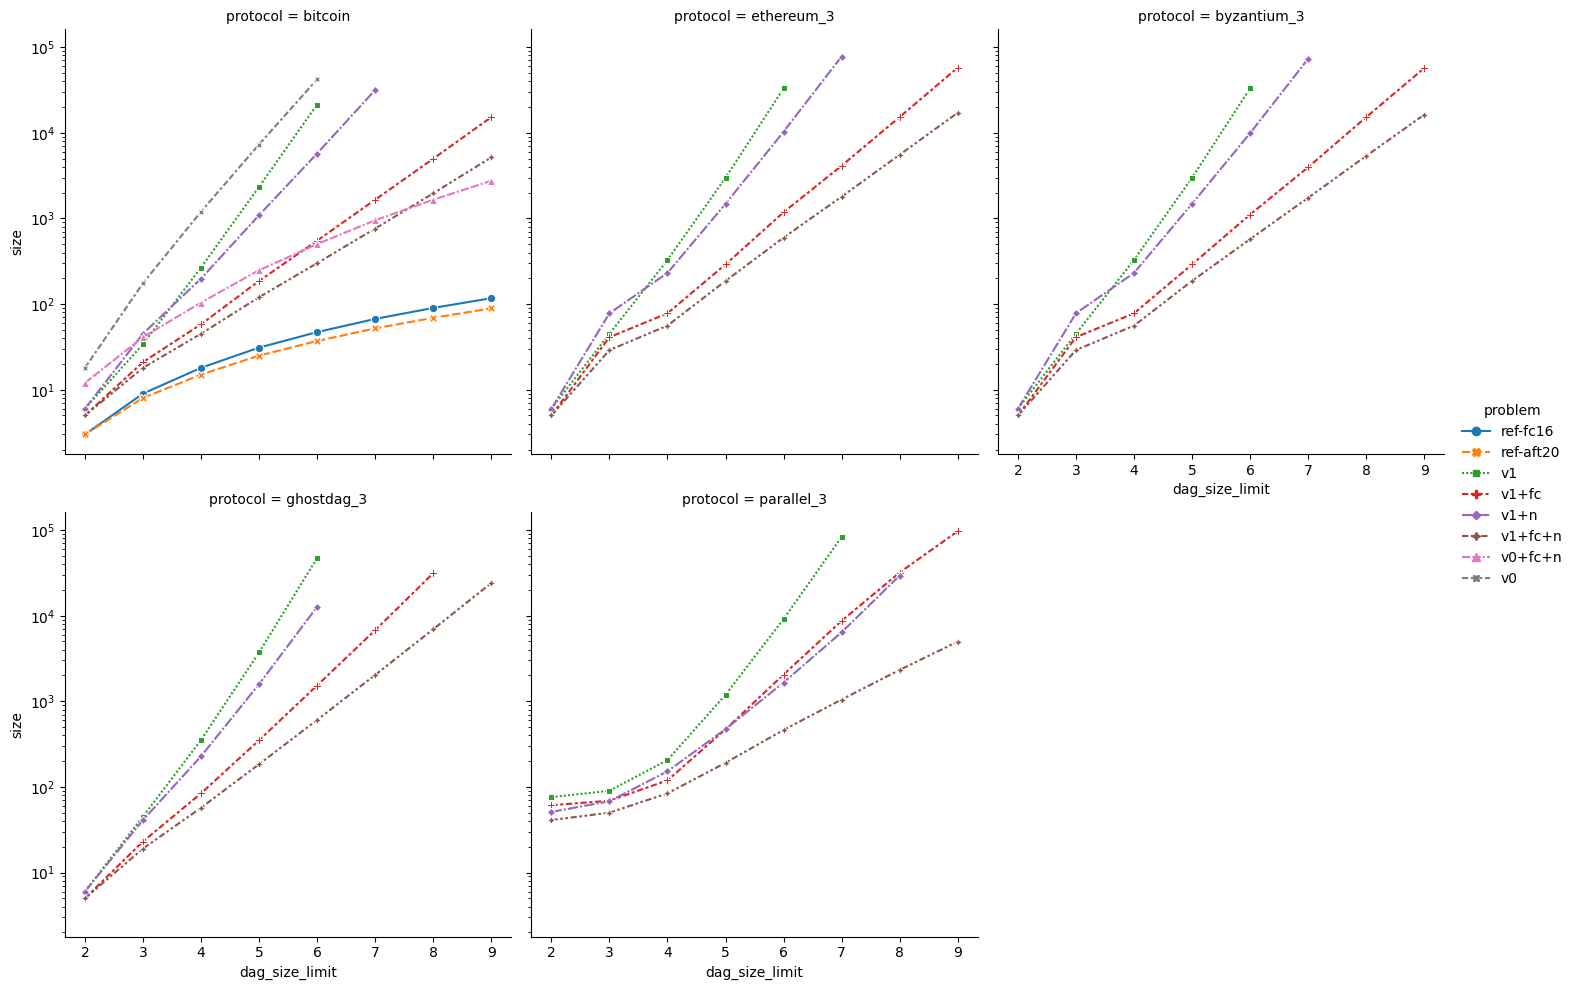

In [2]:
import seaborn

seaborn.relplot(
    data=size_log.query("dag_size_limit < 10"),
    kind="line",
    x="dag_size_limit",
    y="size",
    hue="problem",
    style="problem",
    markers=True,
    col="protocol",
    col_wrap=3,
).set(yscale="log")

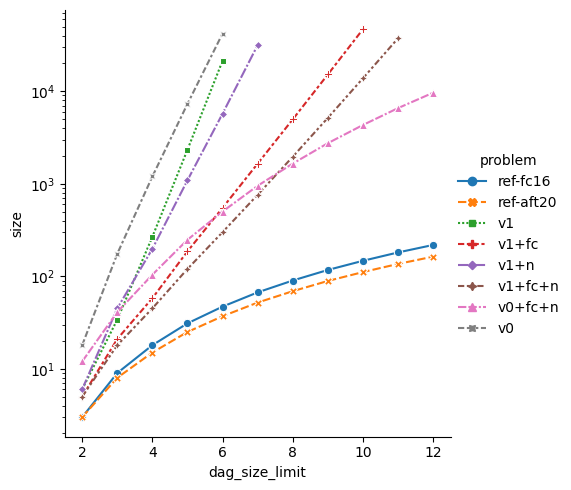

In [3]:
seaborn.relplot(
    data=size_log.query("protocol == 'bitcoin' and dag_size_limit < 13"),
    kind="line",
    x="dag_size_limit",
    y="size",
    hue="problem",
    style="problem",
    markers=True,
).set(yscale="log")

In [4]:
cutoff = (
    max(
        size_log.query(
            "problem.str.startswith('v1') and protocol == 'bitcoin'"
        ).dag_size_limit
    )
    + 1
)

btc_size = (
    size_log.query("protocol == 'bitcoin'")
    .query(f"dag_size_limit <= {cutoff}")
    .loc[:, ["dag_size_limit", "problem", "size"]]
    .drop_duplicates()
    .pivot(index="dag_size_limit", columns="problem", values="size")
)

btc_size.to_csv("5-state-space-exploration-viz-for-paper-btc-size.csv")
btc_size

problem,ref-aft20,ref-fc16,v0,v0+fc+n,v1,v1+fc,v1+fc+n,v1+n
dag_size_limit,,,,,,,,
2,3.0,3.0,18.0,12.0,6.0,5.0,5.0,6.0
3,8.0,9.0,175.0,41.0,34.0,21.0,18.0,45.0
4,15.0,18.0,1198.0,104.0,267.0,58.0,45.0,198.0
5,25.0,31.0,7296.0,248.0,2332.0,186.0,120.0,1090.0
6,37.0,47.0,42041.0,501.0,21327.0,549.0,300.0,5724.0
7,52.0,67.0,NaN,951.0,NaN,1650.0,760.0,31532.0
8,69.0,90.0,NaN,1652.0,NaN,4968.0,1959.0,NaN
9,89.0,117.0,NaN,2744.0,NaN,15172.0,5153.0,NaN
10,111.0,147.0,NaN,4315.0,NaN,46756.0,13794.0,NaN


In [5]:
# how should we report on the other protocols?
# column a: show max depth explored in table for fully optimized exploration only; calculate blow up factor and add as columns


def tabulate_deepest(d):
    return d.iloc[d.groupby(["problem", "protocol"]).dag_size_limit.idxmax()]


biggest = (
    tabulate_deepest(size_log)
    .reset_index(drop=True)
    .query("not problem.str.startswith('v1-')")
)

biggest.to_pickle("5-generated-mdps/biggest.pkl.gz")

biggest

,problem,model,force_consider_own,merge_isomorphic,truncate_common_chain,collect_garbage,reward_common_chain,protocol,dag_size_limit,size,time_spent,rss,mdp
0,ref-aft20,aft20barzur,True,True,True,True,True,bitcoin,283,99688,4.015007,0.624733,114cfaf8
1,ref-fc16,fc16sapirshtein,True,True,True,True,True,bitcoin,239,99247,5.061179,0.624733,5b1ac44b
2,v0,generic-v0,False,False,True,True,True,bitcoin,6,42041,30.546989,0.624146,2fb52d67
3,v0+fc+n,generic-v0,True,True,True,True,True,bitcoin,20,98480,168.578329,0.611855,1c93d17f
4,v1,generic-v1,False,False,True,True,True,bitcoin,6,21327,14.225805,0.340950,54eefb19
5,v1,generic-v1,False,False,True,True,True,byzantium_3,6,33016,25.188465,0.440945,6466d7cd
6,v1,generic-v1,False,False,True,True,True,ethereum_3,6,32961,23.782884,0.440281,284be16c
7,v1,generic-v1,False,False,True,True,True,ghostdag_3,6,46966,38.526995,0.539726,1205a1d7
8,v1,generic-v1,False,False,True,True,True,parallel_3,7,82753,62.674956,0.917686,4a8b5bee
9,v1+fc,generic-v1,True,False,True,True,True,bitcoin,10,46756,43.428593,0.669365,42682a42


In [6]:
# how should we report on the other protocols?
# column b: fix depth in table

fixed_cutoff = min(biggest.dag_size_limit)
fixed = (
    size_log.query("not problem.str.startswith('v1-')")
    .query(f"dag_size_limit == {fixed_cutoff}")
    .reset_index(drop=True)
)
fixed.to_pickle("5-generated-mdps/fixed.pkl.gz")
fixed

,problem,model,force_consider_own,merge_isomorphic,truncate_common_chain,collect_garbage,reward_common_chain,protocol,dag_size_limit,size,time_spent,rss,mdp
0,ref-fc16,fc16sapirshtein,True,True,True,True,True,bitcoin,6,47,0.001592,0.173225,5eefd59e
1,ref-aft20,aft20barzur,True,True,True,True,True,bitcoin,6,37,0.000878,0.173958,18a5bf27
2,v1,generic-v1,False,False,True,True,True,bitcoin,6,21327,14.225805,0.340950,54eefb19
3,v1,generic-v1,False,False,True,True,True,ethereum_3,6,32961,23.782884,0.440281,284be16c
4,v1,generic-v1,False,False,True,True,True,byzantium_3,6,33016,25.188465,0.440945,6466d7cd
5,v1,generic-v1,False,False,True,True,True,ghostdag_3,6,46966,38.526995,0.539726,1205a1d7
6,v1,generic-v1,False,False,True,True,True,parallel_3,6,9122,5.635517,0.279095,457fac67
7,v1+fc,generic-v1,True,False,True,True,True,bitcoin,6,549,0.253419,0.230400,8c968398
8,v1+fc,generic-v1,True,False,True,True,True,ethereum_3,6,1179,0.716968,0.234993,543c3d50
9,v1+fc,generic-v1,True,False,True,True,True,byzantium_3,6,1109,0.745721,0.241741,658fb0e6


In [7]:
combined = pandas.DataFrame(
    dict(
        max_dag_size_limit=biggest.set_index(["problem", "protocol"]).dag_size_limit,
        size_at_fixed_dag_size=fixed.set_index(["problem", "protocol"])["size"],
    )
).reset_index()
combined

,problem,protocol,max_dag_size_limit,size_at_fixed_dag_size
0,ref-aft20,bitcoin,283,37
1,ref-fc16,bitcoin,239,47
2,v0,bitcoin,6,42041
3,v0+fc+n,bitcoin,20,501
4,v1,bitcoin,6,21327
5,v1,byzantium_3,6,33016
6,v1,ethereum_3,6,32961
7,v1,ghostdag_3,6,46966
8,v1,parallel_3,7,9122
9,v1+fc,bitcoin,10,549


In [8]:
fixed_cutoff

6

In [9]:
combined.query('problem.str.startswith("v1")').set_index(
    ["problem", "protocol"]
).unstack(level=0).stack(level=0, future_stack=True).unstack(level=1)

problem                     v1                                     v1+fc  \
            max_dag_size_limit size_at_fixed_dag_size max_dag_size_limit   
protocol                                                                   
bitcoin                      6                  21327                 10   
byzantium_3                  6                  33016                  9   
ethereum_3                   6                  32961                  9   
ghostdag_3                   6                  46966                  8   
parallel_3                   7                   9122                  9   

problem                                       v1+fc+n                         \
            size_at_fixed_dag_size max_dag_size_limit size_at_fixed_dag_size   
protocol                                                                       
bitcoin                        549                 11                    300   
byzantium_3                   1109                 10                    572   
ethereum_3                    1179                 10                    596   
ghostdag_3                    1527                 10                    604   
parallel_3                    2050                 12                    462   

problem                   v1+n                         
            max_dag_size_limit size_at_fixed_dag_size  
protocol                                               
bitcoin                      7                   5724  
byzantium_3                  7                   9879  
ethereum_3                   7                  10293  
ghostdag_3                   6                  12644  
parallel_3                   8                   1654